In [1]:
import pickle
import random
import pandas as pd
import sympy as sp
from scipy.integrate import solve_ivp
import os
import json
import numpy as np
from scipy.spatial import KDTree


with open(r'D:\ucl\pyssem\scenario-properties.pkl', 'rb') as file:
    scenario_properties = pickle.load(file)

In [11]:
# Pre-load and preprocess density data
def preload_density_data(file_path):
    with open(file_path, 'r') as file:
        density_data = json.load(file)
    return density_data

# Precompute date mapping for given t values and date range
def precompute_date_mapping(start_date, end_date, num_points=101):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    total_days = (end_date - start_date).days
    dates = [start_date + pd.to_timedelta(i / (num_points - 1) * total_days, unit='d') for i in range(num_points)]
    date_mapping = [date.strftime('%Y-%m') for date in dates]
    return date_mapping

# Precompute nearest altitude mapping
def precompute_nearest_altitudes(available_altitudes, max_query=2000, resolution=1):
    altitude_tree = KDTree(np.array(available_altitudes).reshape(-1, 1))
    altitude_mapping = {}
    for alt in range(0, max_query + resolution, resolution):
        _, idx = altitude_tree.query([[alt]])
        nearest_alt = available_altitudes[idx[0]]
        altitude_mapping[alt] = nearest_alt
    return altitude_mapping

# Load data
density_data = preload_density_data(r'D:\ucl\pyssem\pyssem\utils\drag\dens_highvar_2000_dens_highvar_2000_lookup.json')
date_mapping = precompute_date_mapping(scenario_properties.start_date, (scenario_properties.start_date + pd.to_timedelta(scenario_properties.simulation_duration)))
available_altitudes = list(map(int, list(density_data['2020-03'].keys())))
available_altitudes.sort()
nearest_altitude_mapping = precompute_nearest_altitudes(available_altitudes)

# Optimized function to use in solve_ivp
def JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping):
    """
    Calculate density at various altitudes based on a percentage through a time range
    using precomputed data for efficiency.

    :param t: Percentage of the way through the simulation, between 0 and 100
    :param h: List of altitudes for which densities are required
    :param density_data: Preloaded density data
    :param date_mapping: Precomputed date mapping
    :param nearest_altitude_mapping: Precomputed nearest altitude mapping
    :return: List of densities corresponding to each altitude in h
    """
    # Compute index for t assuming t is between 0 and 100
    t_index = int(t)
    target_date_str = date_mapping[t_index]

    # Check if the target date is in the dataset
    if target_date_str not in density_data:
        raise ValueError(f"No data available for {target_date_str}")

    # Compute densities for the requested altitudes
    density_values = []
    for alt in h:
        query_alt = min(alt, max(nearest_altitude_mapping.keys()))
        nearest_alt = nearest_altitude_mapping[query_alt]
        density_values.append(density_data[target_date_str][str(nearest_alt)])

    # convert to np.array
    density_values = np.array(density_values)

    return density_values

In [30]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
drag_upper_flattened = [scenario_properties.drag_term_upper[i, j] for j in range(scenario_properties.drag_term_upper.cols) for i in range(scenario_properties.drag_term_upper.rows)]
drag_current_flattened = [scenario_properties.drag_term_cur[i, j] for j in range(scenario_properties.drag_term_cur.cols) for i in range(scenario_properties.drag_term_cur.rows)]

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
drag_upper_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_upper_flattened]
drag_cur_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_current_flattened]

full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [44]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

def population_shell(t, N, full_lambda, equations):
    print(f"Time: {t}")
    dN_dt = np.zeros_like(N)
    
    if scenario_properties.time_dep_density:
        # Get density values for the current time step
        rho = JB2008_dens_func(t, scenario_properties.R0_km, density_data, date_mapping, nearest_altitude_mapping)
        
        # Extend rho for each species within each shell
        rho_full = np.repeat(rho, scenario_properties.species_length)

        num_shells = len(rho)
        species_per_shell = scenario_properties.species_length
        
        for i in range(len(N)):
            shell_index = i // species_per_shell  # Identifies which shell this index belongs to
            species_index = i % species_per_shell  # Identifies which species within the shell this index is
            
            # Current drag force calculations
            current_drag = drag_cur_lamd[i](*N) * rho_full[shell_index]
            dN_dt[i] += current_drag * 0.000001
            
            # Upper drag force calculations unless it's the last shell of its species
            if shell_index < num_shells - 1:
                upper_drag = drag_upper_lamd[i](*N) * rho_full[shell_index + 1]
                dN_dt[i] += upper_drag * 0.000001

            # Handle incoming new species
            if full_lambda[i] is not None:
                increase = np.interp(t, times, full_lambda[i])
                dN_dt[i] += 0 if np.isnan(increase) else increase

            # Apply general equation dynamics
            dN_dt[i] += equations[i](*N)

    return dN_dt


output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_lambda_flattened, equations), 
                    t_eval=scenario_properties.scen_times, method='BDF')

Time: 0.0
Time: 2.698515647976814e-05
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Time: 0.0
Ti

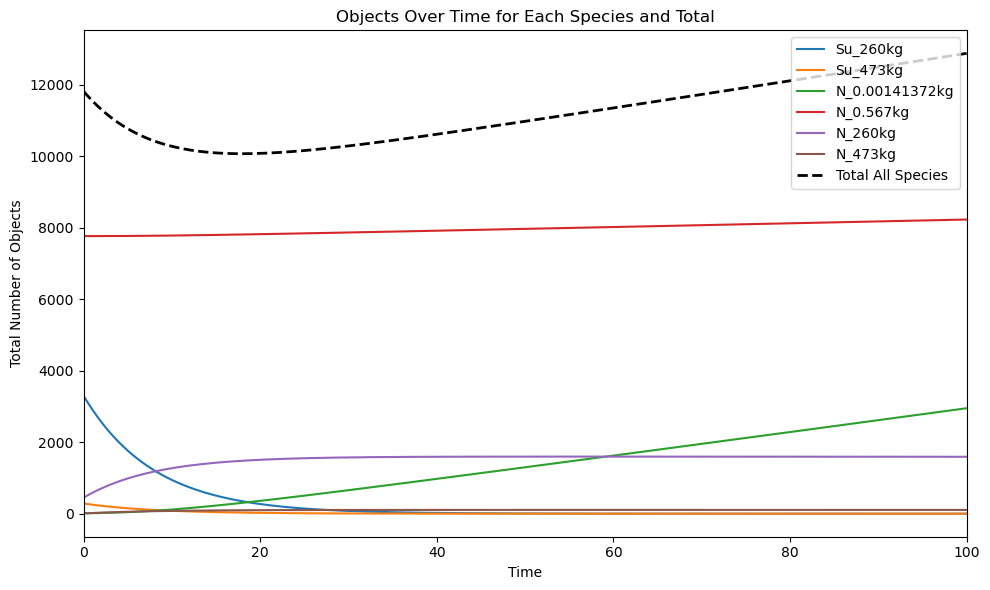

In [45]:
# Assuming scenario_properties.species_names is available
import matplotlib.pyplot as plt # type: ignore
species_names = scenario_properties.species_names

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))


plt.legend()
plt.tight_layout()
plt.show()